# Understanding the Binomial Asset model

In this notebook, we will systematically study the Binomial Asset model, and the wealth equation for simple European put/call options. 

In [55]:
import numpy as np
from functools import wraps
from time import time
from scipy.special import binom
import matplotlib.pyplot as plt

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
jtplot.style()

def timing(f):
    # Create timing wrapper
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r args:[%r, %r] took: %2.4f sec'% (f.__name__, args, kw, te-ts))
        return result
    return wrap

In [56]:

class binomial_tree_european:

    '''
    Binomial asset tree model with different options.

    We need to know several things:
    u, d, S0, T, N, r, K, option
    '''
    def __init__(self, params):

        self.__dict__.update(params)    # load model parameters
        self.dt = self.T/self.N         # Compute time step
        self.disc = (1+self.r)           # Compute discount rate
        self.risk_p = (self.disc - self.d) / (self.u - self.d)  # Compute risk neutral probability
        self.delta0 = self.calculate_delta0()
        self.V0 = self.calculate_V0()
        self.X0 = self.calculate_X0()

    def calculate_Sn(self, n):
        # Compute potential price outcomes
        return self.S0 * self.d ** (np.arange(n, -1, -1)) * self.u ** (np.arange(0, n + 1, 1))

    def VN(self):
        # Compute asset prices at maturity T = N
        if self.option == 'put':
            return np.maximum(self.K - self.calculate_Sn(self.N), np.zeros(self.N+1))
        else:
             return np.maximum(self.calculate_Sn(self.N)-self.K, np.zeros(self.N+1))

    def calculate_V0(self):
        # Compute initial asset price through tree at time n
        C = self.VN()
        for i in np.arange(self.N, 0, -1):
            # C[1:i+1] corresponds to all tails at the end 
            C =  ((self.risk_p) * C[1:i+1] + (1-self.risk_p) * C[0:i])/self.disc

        return C[0]

    def calculate_Vn(self, n):
        # Compute initial asset price through tree at time n
        C = self.VN()
        for i in np.arange(self.N, n, -1):
            C = ((self.risk_p) * C[1:i + 1] + (1-self.risk_p) * C[0:i])/self.disc

        return C

    def calculate_delta0(self):
        # Compute risk neutal share holding
        self.d0 = np.diff(self.calculate_Vn(1))[0]/((self.u-self.d)*self.S0)
        return self.d0

    def calculate_deltan(self, n):
        # Calculate
        return np.diff(self.calculate_Vn(n+1))/np.diff(self.calculate_Sn(n+1))

    def calculate_X0(self):
        # Calculate X0
        return sum((1/self.disc) * self.calculate_Vn(1) * np.array([1-self.risk_p, self.risk_p]))

In [345]:
# Define some system parameters for the model
u = 1.1
p = 0.55
N = 100
K = 30
S0 = 10

params = {'S0': S0,
          'p' : p,
            'r': 0.001,
            'u': u,
            'd': 1/u,
            'K': K,
            'N': N,
            'T': 1,
            'option': 'call'}

# create random model
m = binomial_tree_european(params)

n = N-1

Sn = m.calculate_Sn(n)
Vn = m.calculate_Vn(n)
probs = (1-m.risk_p)**(np.arange(n, -1, -1)) * (m.risk_p)**(np.arange(0, n+1, 1))
probs = (1-m.risk_p)**(np.arange(n, -1, -1)) * (m.risk_p)**(np.arange(0, n+1, 1))
bs = binom(n, np.arange(n+1))
pr = np.array([1-m.risk_p, m.risk_p])
pr_real = np.array([1-p, p])

Sbar =  sum(bs * probs * Sn) * m.disc ** (-n)
Vbar = sum(bs * probs * Vn) * m.disc ** (-n)

# Check that discounted values agree with actual values
print("V0 = ", np.round(m.V0, 3), " and discounted average o Vn = ", np.round(Vbar, 3))
print("S0 = ", m.S0, " and discounted average o Vn = ", np.round(Sbar, 3))

V0 =  1.109  and discounted average o Vn =  1.109
S0 =  10  and discounted average o Vn =  10.0


# Verifying the first step

Double check that the wealth equation agrees with u

In [346]:
# Compute wealth at next time step
X1 = m.delta0 * m.calculate_Sn(1) + m.disc * (m.X0- m.delta0 * m.S0)

# Compute average wealth and replicating porfolio of the underlying under risk neutral probabilities 
X1bar = sum(X1*pr)
V1bar = sum(m.calculate_Vn(1) *pr)

print(X1bar)
print(V1bar)

1.1098437354291104
1.1098437354291106


# Understanding the Wealth equation

In this section

In [347]:
Sn = m.calculate_Sn(n)
dn = m.calculate_deltan(n)
ntraj = 1000
traj = np.random.choice([1,0], size=(n-1, ntraj), p=[m.p, 1-m.p])

Sn = m.S0

Xn = np.zeros((n, ntraj))
Xn_t = np.zeros(n)
dn = np.zeros((n, ntraj))
Sn = np.zeros((n, ntraj))
Vn = np.zeros(n)
Xn[0, :] = m.X0
Xn_t[0] = m.X0
dn[0, :] = m.delta0
Sn[0, :] = m.S0
Vn[0] = m.V0
vi = np.zeros(ntraj, dtype=int)

for i, v in enumerate(traj):
    
#     Keep a tally of 1's correspond to total number of H
    vi += v
    
#     # Now the only pain in the ass is that we need to compute all the dn's
    Sn[i+1, :] = Sn[i] * (m.u)**(v) * (m.d)**(1-v)
    Xn[i+1, :] = dn[i, :] * Sn[i+1, :] + m.disc * (Xn[i, :] -  dn[i, :] * Sn[i, :])
    dn[i+1, :] = m.calculate_deltan(i+1)[vi]
    
    # Compute Assest prices
    probs = (1-m.risk_p)**(np.arange(i+1, -1, -1)) * (m.risk_p)**(np.arange(0, i+2, 1))*binom(i+1, np.arange(i+2))
    Vn[i+1] =sum(m.calculate_Vn(i+1) * probs)


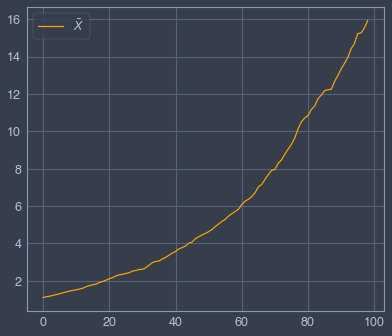

In [348]:
# Compute in real terms
Xn_real = (Xn.T/(m.disc**np.arange(n))).T
Sn_real = (Sn.T/(m.disc**np.arange(n))).T
Xn_t_real = Xn_t/(m.disc**np.arange(n))
Vn_real = Vn/(m.disc**np.arange(n))

# Compute mean
Xn_mean = np.mean(Xn_real, axis=1)
Sn_mean= np.mean(Sn_real, axis=1)
dn_mean = np.mean(dn, axis=1)

plt.plot(Xn_mean , color='orange', label=r'$\bar{X}$')
# plt.plot(dn_mean , color='r', label=r'$\bar{\Delta}_{0}$')

plt.legend()
plt.show()
# plt.hlines(m.X0, 0, 100)

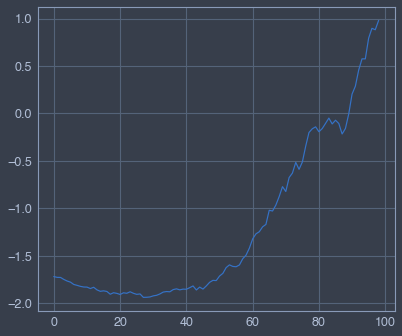

In [349]:
plt.plot(Xn_mean - Sn_mean*dn_mean)
plt.show()

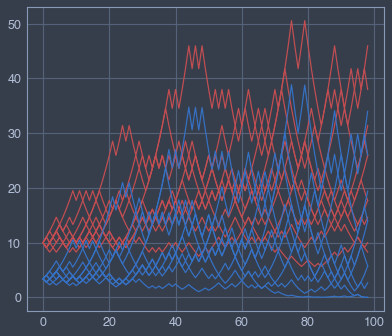

In [339]:
plt.plot(Sn[:, :10], 'r')
plt.plot(Xn[:, :10], 'b')
plt.show()

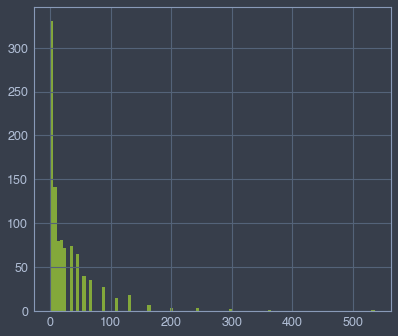

In [320]:
payoffs = Sn[-1,:] - K
payoffs[payoffs<0] = 0

plt.hist(payoffs, bins=100, color='r')
plt.hist(Xn[-1,:], bins=100, color='g')

# plt.xscale('log')

plt.show()

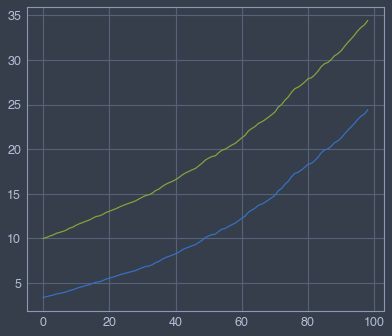

In [321]:
plt.plot(Xn_mean, 'b')
plt.plot(Sn_mean, 'g')

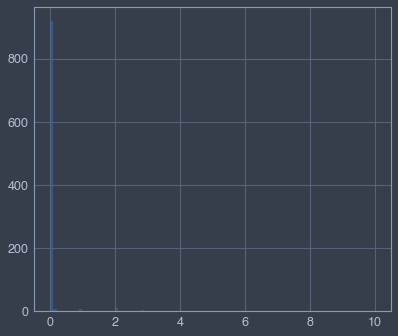

In [244]:
plt.hist(Xn[-1, :], color='b', alpha=0.5, range=[0,10], bins=100)

plt.show()

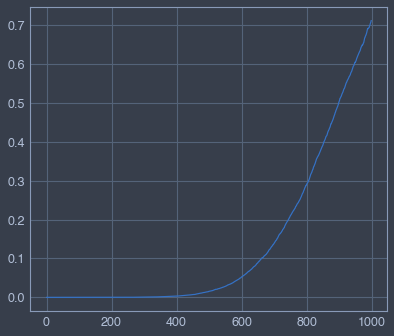

In [1567]:
plt.plot(np.mean(dn, axis=1))
plt.show()

In [1072]:
m.calculate_V0()

5.774614451235375

In [1073]:
m.calculate_Vn(n)

array([6.92873994, 6.92288057, 6.89944307, 6.80569307, 6.43069307,
       4.93069307, 1.96039604, 0.        , 0.        , 0.        ])

In [836]:
m.disc

1.01

In [837]:
m.d

0.9523809523809523